# Midterm Part 1 - _Due Monday, September 19_
---
## Note: this is part of the midterm. It is _not_ a paired programming assignment. **You must complete this lab _on your own_**. 
---
### We'll be exploring the Pokemon dataset from [Kaggle](http://www.kaggle.com).
The dataset was downloaded from https://www.kaggle.com/abcsds/pokemon. 

1. sign up or log in
2. accept terms and conditions (if necessary)
3. download `pokemon.zip`
4. unzip it to your local directory

After loading and cleaning the data:

+ **SQL**: 
    - Which Pokemon seems the most useful (largest `Total` value)?
    - Come up with at least one other question that can be answered using SQL (and answer it).
+ **EDA**: 
    - Calculate the percent of distinct Pokemon that are Legendary (distinct means unique Pokemon `#`).
    - Make at least one barplot of a categorical variable
    - Make at least one boxplot of continuous variables
    - Make at least one boxplot of continuous variables grouped by a categorical variable
+ **EDA/Statistics**: 
    - Calculate the mean and standard deviation of the `total` column for each Pokemon Type 1.
    - Calculate the mean and standard deviation of at least one other continuous variable
+ **Statistics/Random Sampling** - For the following questions, draw a sample of 100:
    - Compare sample statistics & population statistics for Attack points.
    - Make histograms of the Attack points sample & Attack points population.
    - Compare sample statistics & population statistics for at least one other continuous variable.
    - Make histograms of the Attack points sample & at least one other continuous variable in the population.
+ **Probability**: Assume you are a Pokemaster and have caught every Pokemon. You pick 6 Pokemon at random to carry.
     - What's the probability that they are all Water type? (probability of a Pokemon with Type 1 or Type 2 of `Water`)
     - Come up with at least one more scenario for your set of six Pokemon and compute the probability of getting it.

***
## Setup & clean the data
### First, load the packages that will be used in this notebook.

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import seaborn as sns

from sqlalchemy import create_engine

random.seed(1234)
sns.set(font_scale=1.5)

Populating the interactive namespace from numpy and matplotlib


### Next, load the csv file into a DataFrame and look at the first few lines.

In [74]:
pkmn = pd.read_csv('Pokemon.csv')
pkmn.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Here are some variable descriptions from the Kaggle website:

|Variable|Description|
|:-:|:--|
|**#**|ID for each pokemon|
|**Name**|Name of each pokemon|
|**Type 1**|Each pokemon has a type, this determines weakness/resistance to attacks|
|**Type 2**|Some pokemon are dual type and have 2|
|**Total**|sum of all stats that come after this, a general guide to how strong a pokemon is|
|**HP**|hit points, or health, defines how much damage a pokemon can withstand before fainting|
|**Attack**|the base modifier for normal attacks (eg. Scratch, Punch)|
|**Defense**|the base damage resistance against normal attacks|
|**SP. Atk**|special attack, the base modifier for special attacks (e.g. fire blast, bubble beam)|
|**SP. Def**|the base damage resistance against special attacks|
|**Speed**|determines which pokemon attacks first each round|
|**Generation**|the number of the generation a pokemon belongs to
|**Legendary**|boolean value indicating if a pokemon is Legendary (True) or not Legendary (False)|

Notice that there are multiple entries for Pokemon \#3 (Venusaur). We won't be able to set `#` as the index since it contains duplicates.

We can also modify the column names to get rid of periods and spaces. The column names should also be lowercased for use with SQLite.

In [75]:
# Lowercase and replace periods & spaces in the column names
new_names = []

for col in pkmn.columns:
    new_names.append(col.replace('.', '', len(col)).replace(' ', '', len(col)).lower())

pkmn.columns = new_names

print(pkmn.columns)

Index(['#', 'name', 'type1', 'type2', 'total', 'hp', 'attack', 'defense',
       'spatk', 'spdef', 'speed', 'generation', 'legendary'],
      dtype='object')


In [76]:
pkmn.head()

,#,name,type1,type2,total,hp,attack,defense,spatk,spdef,speed,generation,legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Let's also convert `Legendary` to a binary column, where `1` represents `True` and `0` represents `False`.

Python's lambda functions are useful for defining functions in-line. You can read more at:<br>
https://pythonconquerstheuniverse.wordpress.com/2011/08/29/lambda_tutorial/<br>
http://stackoverflow.com/questions/890128/why-are-python-lambdas-useful

In [77]:
pkmn['legendary'] = pkmn['legendary'].apply(lambda x: 1 if x == True else 0)
pkmn.head()

,#,name,type1,type2,total,hp,attack,defense,spatk,spdef,speed,generation,legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,0
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,0


### Next, load the data into SQL

First we'll need to create a database, then create a table in our new database.

In [78]:
# Create pokemon table in pokemon database (only run this once!)
engine = create_engine('sqlite:///pokemon.db')
conn = engine.connect()
pkmn.to_sql('pokemon', conn)

ValueError: Table 'pokemon' already exists.

# SQL

In [7]:
%load_ext sql

/Users/victorvulovic/anaconda/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/victorvulovic/anaconda/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [8]:
%sql sqlite:///pokemon.db

'Connected: None@pokemon.db'

In [9]:
%%sql
SELECT name, MAX(total) AS total FROM pokemon;

Done.


name,total
MewtwoMega Mewtwo X,780


In [10]:
#who are the most powerful pokemon by type1?

In [11]:
%%sql
SELECT name, type1, MAX(total) AS total FROM pokemon GROUP BY type1;

Done.


name,type1,total
PinsirMega Pinsir,Bug,600
Yveltal,Dark,680
RayquazaMega Rayquaza,Dragon,780
AmpharosMega Ampharos,Electric,610
Xerneas,Fairy,680
LucarioMega Lucario,Fighting,625
Ho-oh,Fire,680
TornadusIncarnate Forme,Flying,580
GiratinaAltered Forme,Ghost,680
SceptileMega Sceptile,Grass,630


In [79]:
pkmn = pkmn.rename(columns={'#' : 'num'})

Calculate the percent of distinct Pokemon that are Legendary (distinct means unique Pokemon #).

In [80]:
pkmn.head()

,num,name,type1,type2,total,hp,attack,defense,spatk,spdef,speed,generation,legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,0
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,0


In [81]:
legendary = pd.DataFrame(pkmn.groupby('legendary').num.nunique())
legendary

,num
legendary,
0,675
1,46


# EDA

In [15]:
percent = (legendary.iloc[1] / legendary.iloc[0])
percent.round(5)

num    0.06815
dtype: float64

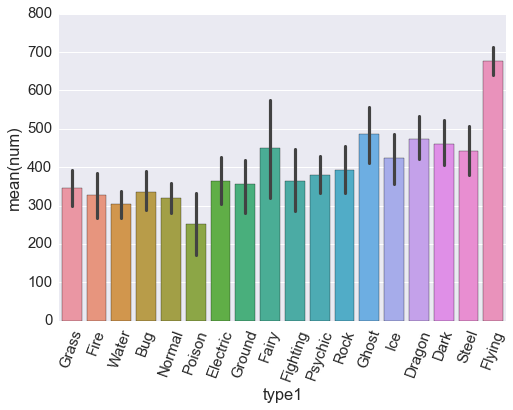

In [82]:
type1 = sns.barplot(x='type1', y='num', data=pkmn)
for item in type1.get_xticklabels():
    item.set_rotation(70)

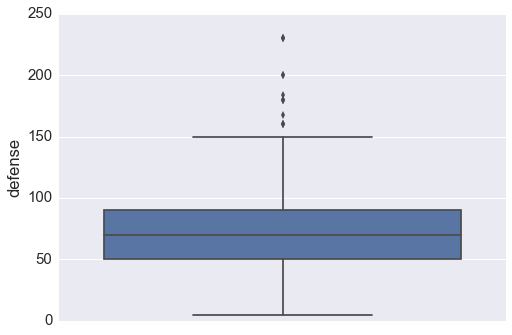

In [83]:
sns.boxplot(y='defense', data=pkmn);

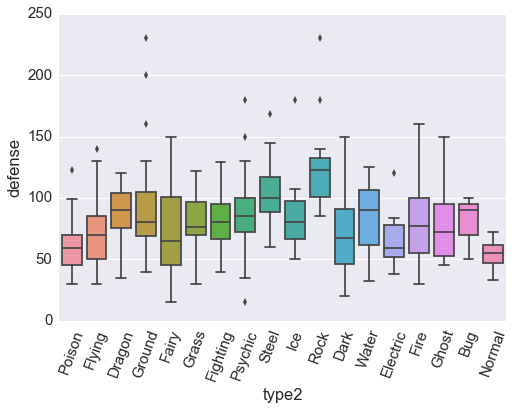

In [84]:
def_type2 = sns.boxplot(x='type2', y='defense', data=pkmn)
for item in def_type2.get_xticklabels():
    item.set_rotation(70)

# EDA/Statistics

In [91]:
total_mean = pd.DataFrame(pkmn.groupby('type1').mean())
pd.DataFrame(total_mean['total'])

,total
type1,
Bug,378.927536
Dark,445.741935
Dragon,550.531250
Electric,443.409091
Fairy,413.176471
Fighting,416.444444
Fire,458.076923
Flying,485.000000
Ghost,439.562500


In [95]:
total_std = pd.DataFrame(pkmn.groupby('type1').std())
pd.DataFrame(total_std['total'])

,total
type1,
Bug,117.875223
Dark,109.126217
Dragon,146.267538
Electric,105.721952
Fairy,123.781680
Fighting,102.464378
Fire,109.760496
Flying,161.400124
Ghost,110.072685


In [93]:
defense_mean = pd.DataFrame(pkmn.groupby('type1').mean())
pd.DataFrame(defense_mean['defense'])

,defense
type1,
Bug,70.724638
Dark,70.225806
Dragon,86.375000
Electric,66.295455
Fairy,65.705882
Fighting,65.925926
Fire,67.769231
Flying,66.250000
Ghost,81.187500


In [94]:
defense_std = pd.DataFrame(pkmn.groupby('type1').std())
pd.DataFrame(defense_std['defense'])

,defense
type1,
Bug,33.617609
Dark,25.121982
Dragon,24.102938
Electric,24.757033
Fairy,18.979478
Fighting,18.578163
Fire,23.658200
Flying,21.360009
Ghost,32.551138


+ **SQL**: 
    - Which Pokemon seems the most useful (largest `Total` value)?
    - Come up with at least one other question that can be answered using SQL (and answer it).
+ **EDA**: 
    - Calculate the percent of distinct Pokemon that are Legendary (distinct means unique Pokemon `#`).
    - Make at least one barplot of a categorical variable
    - Make at least one boxplot of continuous variables
    - Make at least one boxplot of continuous variables grouped by a categorical variable
+ **EDA/Statistics**: 
    - Calculate the mean and standard deviation of the `total` column for each Pokemon Type 1.
    - Calculate the mean and standard deviation of at least one other continuous variable
+ **Statistics/Random Sampling** - For the following questions, draw a sample of 100:
    - Compare sample statistics & population statistics for Attack points.
    - Make histograms of the Attack points sample & Attack points population.
    - Compare sample statistics & population statistics for at least one other continuous variable.
    - Make histograms of the Attack points sample & at least one other continuous variable in the population.
+ **Probability**: Assume you are a Pokemaster and have caught every Pokemon. You pick 6 Pokemon at random to carry.
     - What's the probability that they are all Water type? (probability of a Pokemon with Type 1 or Type 2 of `Water`)
     - Come up with at least one more scenario for your set of six Pokemon and compute the probability of getting it.

# Statistics/Random Sampling

In [99]:
pkmn_sample = pd.DataFrame(pkmn.sample(100))
pkmn_sample.head()

,num,name,type1,type2,total,hp,attack,defense,spatk,spdef,speed,generation,legendary
338,310,Manectric,Electric,NaN,475,70,75,60,105,60,105,3,0
700,639,Terrakion,Rock,Fighting,580,91,129,90,72,90,108,5,1
401,366,Clamperl,Water,NaN,345,35,64,85,74,55,32,3,0
294,271,Lombre,Water,Grass,340,60,50,50,60,70,50,3,0
374,342,Crawdaunt,Water,Dark,468,63,120,85,90,55,55,3,0


In [126]:
µ_attack = pd.DataFrame(pkmn['attack'].describe()) 
xbar_attack = pd.DataFrame(pkmn_sample['attack'].describe())

In [127]:
µ_attack

,attack
count,800.000000
mean,79.001250
std,32.457366
min,5.000000
25%,55.000000
50%,75.000000
75%,100.000000
max,190.000000


In [128]:
xbar_attack

,attack
count,100.000000
mean,78.990000
std,35.883227
min,5.000000
25%,54.750000
50%,76.000000
75%,100.000000
max,185.000000


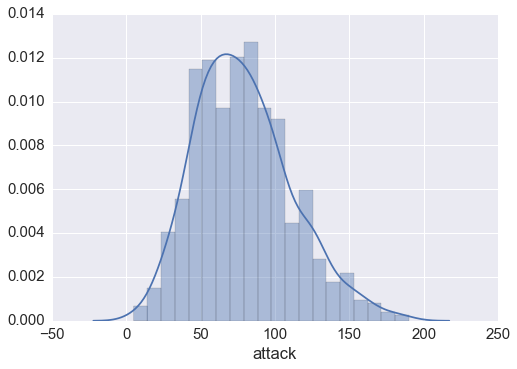

In [110]:
µ = pkmn['attack']
xbar = pkmn_sample['attack']
sns.distplot(µ);

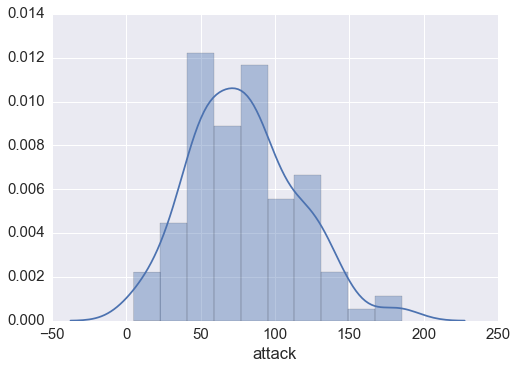

In [111]:
sns.distplot(xbar);

In [129]:
µ_defense = pd.DataFrame(pkmn['defense'].describe()) 
xbar_defense = pd.DataFrame(pkmn_sample['defense'].describe())

In [130]:
µ_defense

,defense
count,800.000000
mean,73.842500
std,31.183501
min,5.000000
25%,50.000000
50%,70.000000
75%,90.000000
max,230.000000


In [131]:
xbar_defense

,defense
count,100.000000
mean,74.540000
std,36.699275
min,5.000000
25%,50.000000
50%,71.000000
75%,90.000000
max,230.000000


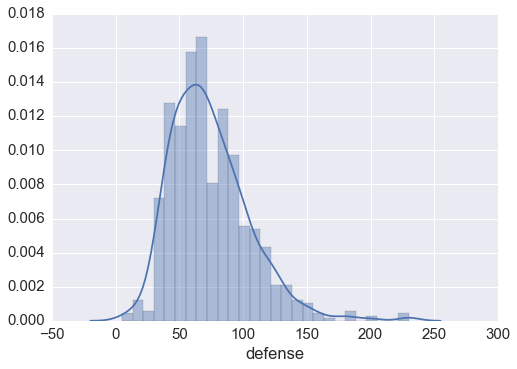

In [121]:
mud = pkmn['defense']
xbard = pkmn_sample['defense']
sns.distplot(mud);

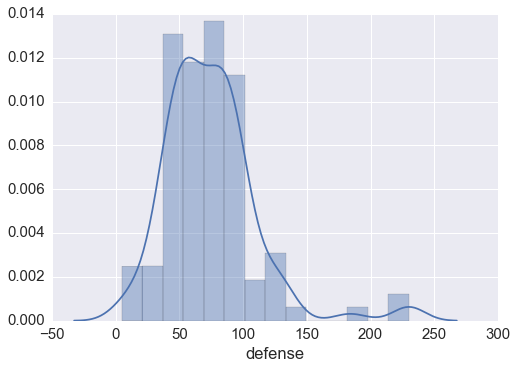

In [122]:
sns.distplot(xbard);

# Probability

+ **SQL**: 
    - Which Pokemon seems the most useful (largest `Total` value)?
    - Come up with at least one other question that can be answered using SQL (and answer it).
+ **EDA**: 
    - Calculate the percent of distinct Pokemon that are Legendary (distinct means unique Pokemon `#`).
    - Make at least one barplot of a categorical variable
    - Make at least one boxplot of continuous variables
    - Make at least one boxplot of continuous variables grouped by a categorical variable
+ **EDA/Statistics**: 
    - Calculate the mean and standard deviation of the `total` column for each Pokemon Type 1.
    - Calculate the mean and standard deviation of at least one other continuous variable
+ **Statistics/Random Sampling** - For the following questions, draw a sample of 100:
    - Compare sample statistics & population statistics for Attack points.
    - Make histograms of the Attack points sample & Attack points population.
    - Compare sample statistics & population statistics for at least one other continuous variable.
    - Make histograms of the Attack points sample & at least one other continuous variable in the population.
+ **Probability**: Assume you are a Pokemaster and have caught every Pokemon. You pick 6 Pokemon at random to carry.
     - What's the probability that they are all Water type? (probability of a Pokemon with Type 1 or Type 2 of `Water`)
     - Come up with at least one more scenario for your set of six Pokemon and compute the probability of getting it.

In [148]:
%%sql
SELECT COUNT(*) type1, COUNT(*) type2 FROM pokemon WHERE type1 = 'Water' OR type2 = 'Water'

Done.


type1,type2
126,126


In [149]:
typed_pkmn = pd.Series(pd.concat([pkmn['type1'].dropna(), pkmn['type2'].dropna()]))
typed_pkmn.head()

0    Grass
1    Grass
2    Grass
3    Grass
4     Fire
dtype: object

In [154]:
sum(typed_pkmn.str.contains("Water"))


126

In [160]:
P_six_water_type = (126/800)*(125/799)*(124/798)*(123/797)*(122/796)*(121/795)
round(P_six_water_type, 8)

1.378e-05

Probability of choosing 6 Water type in a row is 0.001378%. Work show in cell above.

For self-directed probability scenario, I want to know the probability of choosing a pokemon with 'total' of 500 or more and that it's a water type, P(T>500 intersect Water). Work shown below.

In [168]:
%%sql
SELECT (SELECT COUNT(*) total FROM pokemon WHERE total >= 500) * 100. / (SELECT COUNT(*) total FROM pokemon) AS percent;

Done.


percent
30.875


In [172]:
pTover_five = .30875
water_type = sum(typed_pkmn.str.contains("Water"))/len(pkmn)
water_type

0.1575

In [173]:
P_T_intersect_water = pTover_five * water_type
P_T_intersect_water

0.048628125000000001